In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [4]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [9]:
all_features = pd.concat((train_data.iloc[:, 1: -1], test_data.iloc[:, 1:-1]))

In [10]:
all_features.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  2919.000000  2433.000000    2919.000000  2919.000000  2919.000000   
mean     57.137718    69.305795   10168.114080     6.089072     5.564577   
std      42.517628    23.344905    7886.996359     1.409947     1.113131   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7478.000000     5.000000     5.000000   
50%      50.000000    68.000000    9453.000000     6.000000     5.000000   
75%      70.000000    80.000000   11570.000000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  2919.000000   2919.000000  2896.000000  2918.000000  2918.000000  ...   
mean   1971.312778   1984.264474   102.201312   441.423235    49.582248  ...   
std      30.291442     20.894344   179.334253   455.610826   169.205611  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1953.500000   1965.000000     0.000000     0.000000     0.000000  ...   
50%    1973.000000   1993.000000     0.000000   368.500000     0.000000  ...   
75%    2001.000000   2004.000000   164.000000   733.000000     0.000000  ...   
max    2010.000000   2010.000000  1600.000000  5644.000000  1526.000000  ...   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  2918.000000  2919.000000  2919.000000    2919.000000  2919.000000   
mean    472.874572    93.709832    47.486811      23.098321     2.602261   
std     215.394815   126.526589    67.575493      64.244246    25.188169   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     320.000000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    26.000000       0.000000     0.000000   
75%     576.000000   168.000000    70.000000       0.000000     0.000000   
max    1488.000000  1424.000000   742.000000    1012.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  
count  2919.000000  2919.000000   2919.000000  2919.000000  2919.000000  
mean     16.062350     2.251799     50.825968     6.213087  2007.792737  
std      56.184365    35.663946    567.402211     2.714762     1.314964  
min       0.000000     0.000000      0.000000     1.000000  2006.000000  
25%       0.000000     0.000000      0.000000     4.000000  2007.000000  
50%       0.000000     0.000000      0.000000     6.000000  2008.000000  
75%       0.000000     0.000000      0.000000     8.000000  2009.000000  
max     576.000000   800.000000  17000.000000    12.000000  2010.000000  

[8 rows x 36 columns]

### standardize all numeric feature

In [11]:
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler

# # 只选数值列
# numeric_features = all_features.select_dtypes(include=['number']).columns

# # 构造 Pipeline：先用均值填充缺失，再做 Z‑score 标准化
# num_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),   # 等价于后面标准化后填 0
#     ('scaler',  StandardScaler())                  # (x - mean) / std
# ])

# # 在原 DataFrame 上就地替换
# all_features[numeric_features] = num_pipeline.fit_transform(all_features[numeric_features])

# # 再检查一下统计量
# all_features.describe()


In [12]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [13]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [14]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                              dtype=torch.float32)

train_labels = torch.tensor(train_data['SalePrice'].values.reshape(-1, 1),
                            dtype=torch.float32)

In [15]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 20),
                        nn.ReLU(),
                        nn.Linear(20, 1))
    return net

In [ ]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    # print(net(features))
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [17]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [18]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    # 每一折验证集的大小（向下取整）
    fold_size = X.shape[0] // k

    # 初始化训练集容器
    X_train, y_train = None, None

    # 遍历每一折的索引 j
    for j in range(k):
        # 本折的样本索引区间 [j*fold_size, (j+1)*fold_size)
        idx = slice(j * fold_size, (j + 1) * fold_size)
        # 划出这一折的数据
        X_part, y_part = X[idx, :], y[idx]

        if j == i:
            # 如果是第 i 折，就当作验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            # 第一次遇到训练折，就直接赋值
            X_train, y_train = X_part, y_part
        else:
            # 后续的训练折，拼接到已有训练集合里（按第 0 维堆叠）
            X_train = torch.cat([X_train, X_part], dim=0)
            y_train = torch.cat([y_train, y_part], dim=0)

    # 返回：训练特征、训练标签、验证特征、验证标签
    return X_train, y_train, X_valid, y_valid



In [19]:
def k_fold(k, X_train, y_train,
           num_epochs, learning_rate,
           weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0.0, 0.0

    for i in range(k):
        # 划分第 i 折的训练/验证数据
        data = get_k_fold_data(k, i, X_train, y_train)

        # 为新折重置一个网络
        net = get_net()

        # 调用 train() 得到两部分误差列表
        train_ls, valid_ls = train(
            net, *data,
            num_epochs, learning_rate,
            weight_decay, batch_size
        )

        # 取每折训练 & 验证的最后一个 epoch 的误差累加
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        # 仅在第 1 折时绘图：对比训练 & 验证误差随 epoch 变化
        if i == 0:
            d2l.plot(
                list(range(1, num_epochs + 1)),
                [train_ls, valid_ls],
                xlabel='epoch', ylabel='rmse',
                xlim=[1, num_epochs],
                legend=['train', 'valid'],
                yscale='log'
            )

        # 打印当折的最终误差，方便观察每一折的差异
        print(f'折{i + 1}，'
              f'训练 log rmse {train_ls[-1]:.6f}, '
              f'验证 log rmse {valid_ls[-1]:.6f}')

    # 返回 k 折平均的训练 & 验证误差
    return train_l_sum / k, valid_l_sum / k


tensor([[250.0004],
        [337.3664],
        [307.1163],
        ...,
        [281.3160],
        [209.5285],
        [275.0626]], grad_fn=<AddmmBackward0>)
tensor([[319.8197],
        [275.1996],
        [334.5326],
        [253.4949],
        [404.4750],
        [269.2175],
        [370.3192],
        [339.3883],
        [219.6234],
        [173.4250],
        [224.7971],
        [414.6094],
        [222.6085],
        [354.2590],
        [258.5468],
        [225.8447],
        [248.3136],
        [190.4123],
        [290.7958],
        [216.8360],
        [416.3370],
        [182.4056],
        [359.0132],
        [257.0451],
        [249.5142],
        [374.5669],
        [228.6823],
        [378.8869],
        [309.9598],
        [135.9137],
        [163.9049],
        [245.4425],
        [294.7844],
        [272.8332],
        [347.5235],
        [391.8491],
        [295.7065],
        [274.1996],
        [226.9212],
        [140.9804],
        [282.4040],
        [261.7544],


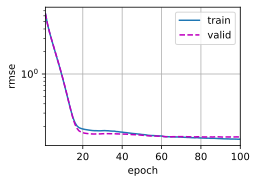

In [20]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.05, 0.1, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [21]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

tensor([[973.0197],
        [831.6002],
        [997.6715],
        ...,
        [847.9869],
        [629.4840],
        [828.2034]], grad_fn=<AddmmBackward0>)
tensor([[4830.2471],
        [4212.2632],
        [4990.9365],
        ...,
        [4316.3926],
        [3244.3164],
        [4201.8208]], grad_fn=<AddmmBackward0>)
tensor([[13242.0684],
        [11568.9688],
        [13702.2793],
        ...,
        [11925.3281],
        [ 8960.1436],
        [11474.8535]], grad_fn=<AddmmBackward0>)
tensor([[26827.9766],
        [23412.6270],
        [27776.0078],
        ...,
        [24207.4844],
        [18056.4336],
        [23170.3750]], grad_fn=<AddmmBackward0>)
tensor([[45210.4141],
        [39444.3906],
        [46842.8555],
        ...,
        [40877.9102],
        [30104.9141],
        [39001.1328]], grad_fn=<AddmmBackward0>)
tensor([[67671.9219],
        [58706.1523],
        [69966.6484],
        ...,
        [60781.1367],
        [44761.7031],
        [58166.6758]], grad_fn=<Add

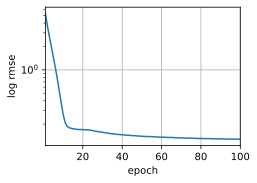

In [22]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)